In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor

transform = transforms.ToTensor()



# get the training datasets
train_data = datasets.MNIST(root='.././data/mnist', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

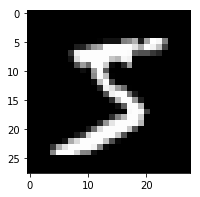

In [4]:

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out


In [6]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

In [7]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32


In [8]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size).to(device)
G = Generator(z_size, g_hidden_size, g_output_size).to(device)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


In [9]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
        labels = labels.to(device)
    else:
        labels = torch.ones(batch_size) # real labels = 1
        labels = labels.to(device)
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [10]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [11]:
import pickle as pkl

# training hyperparams
num_epochs = 200

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.to(device)

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        real_images = real_images.to(device)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  200] | d_loss: 1.3901 | g_loss: 0.6917


/home/mahfuj/pytorch_new_python3/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  200] | d_loss: 0.9239 | g_loss: 3.2901
Epoch [    1/  200] | d_loss: 1.3213 | g_loss: 1.4916
Epoch [    2/  200] | d_loss: 1.5949 | g_loss: 0.8954
Epoch [    2/  200] | d_loss: 1.3460 | g_loss: 0.9594
Epoch [    2/  200] | d_loss: 1.1456 | g_loss: 0.9916
Epoch [    3/  200] | d_loss: 1.4023 | g_loss: 1.4175
Epoch [    3/  200] | d_loss: 0.7287 | g_loss: 2.0174
Epoch [    3/  200] | d_loss: 0.9933 | g_loss: 1.7293
Epoch [    4/  200] | d_loss: 1.0287 | g_loss: 1.4693
Epoch [    4/  200] | d_loss: 1.2339 | g_loss: 1.4027
Epoch [    4/  200] | d_loss: 1.1686 | g_loss: 1.2899
Epoch [    5/  200] | d_loss: 0.9863 | g_loss: 1.6943
Epoch [    5/  200] | d_loss: 1.1272 | g_loss: 1.3476
Epoch [    5/  200] | d_loss: 1.0238 | g_loss: 1.5250
Epoch [    6/  200] | d_loss: 1.2012 | g_loss: 1.0974
Epoch [    6/  200] | d_loss: 1.0158 | g_loss: 2.0518
Epoch [    6/  200] | d_loss: 1.2588 | g_loss: 1.0513
Epoch [    7/  200] | d_loss: 1.2358 | g_loss: 1.0293
Epoch [    7/  200] | d_loss

Epoch [   52/  200] | d_loss: 1.3421 | g_loss: 1.1017
Epoch [   52/  200] | d_loss: 1.2849 | g_loss: 0.9974
Epoch [   52/  200] | d_loss: 1.2420 | g_loss: 1.4093
Epoch [   53/  200] | d_loss: 1.2492 | g_loss: 0.9516
Epoch [   53/  200] | d_loss: 1.1944 | g_loss: 1.5245
Epoch [   53/  200] | d_loss: 1.2624 | g_loss: 0.9432
Epoch [   54/  200] | d_loss: 1.3072 | g_loss: 0.9223
Epoch [   54/  200] | d_loss: 1.2181 | g_loss: 1.0590
Epoch [   54/  200] | d_loss: 1.3201 | g_loss: 0.9379
Epoch [   55/  200] | d_loss: 1.2987 | g_loss: 1.2761
Epoch [   55/  200] | d_loss: 1.2661 | g_loss: 1.0050
Epoch [   55/  200] | d_loss: 1.2119 | g_loss: 1.1316
Epoch [   56/  200] | d_loss: 1.3640 | g_loss: 0.9414
Epoch [   56/  200] | d_loss: 1.2634 | g_loss: 0.9066
Epoch [   56/  200] | d_loss: 1.3922 | g_loss: 1.0154
Epoch [   57/  200] | d_loss: 1.2133 | g_loss: 0.9867
Epoch [   57/  200] | d_loss: 1.2045 | g_loss: 0.9957
Epoch [   57/  200] | d_loss: 1.3430 | g_loss: 1.2658
Epoch [   58/  200] | d_loss

Epoch [  102/  200] | d_loss: 1.4412 | g_loss: 1.0689
Epoch [  103/  200] | d_loss: 1.3269 | g_loss: 0.9974
Epoch [  103/  200] | d_loss: 1.2970 | g_loss: 1.0615
Epoch [  103/  200] | d_loss: 1.3654 | g_loss: 1.0799
Epoch [  104/  200] | d_loss: 1.2214 | g_loss: 1.5638
Epoch [  104/  200] | d_loss: 1.2480 | g_loss: 1.0084
Epoch [  104/  200] | d_loss: 1.3666 | g_loss: 1.0766
Epoch [  105/  200] | d_loss: 1.2557 | g_loss: 1.0566
Epoch [  105/  200] | d_loss: 1.2637 | g_loss: 0.9711
Epoch [  105/  200] | d_loss: 1.3622 | g_loss: 1.0192
Epoch [  106/  200] | d_loss: 1.3619 | g_loss: 1.0160
Epoch [  106/  200] | d_loss: 1.2868 | g_loss: 1.5388
Epoch [  106/  200] | d_loss: 1.3227 | g_loss: 1.2151
Epoch [  107/  200] | d_loss: 1.2796 | g_loss: 1.0411
Epoch [  107/  200] | d_loss: 1.2862 | g_loss: 0.9608
Epoch [  107/  200] | d_loss: 1.2984 | g_loss: 1.1411
Epoch [  108/  200] | d_loss: 1.3128 | g_loss: 0.9598
Epoch [  108/  200] | d_loss: 1.3416 | g_loss: 0.8829
Epoch [  108/  200] | d_loss

Epoch [  153/  200] | d_loss: 1.2884 | g_loss: 0.9630
Epoch [  153/  200] | d_loss: 1.3639 | g_loss: 1.1416
Epoch [  154/  200] | d_loss: 1.3291 | g_loss: 0.9115
Epoch [  154/  200] | d_loss: 1.1060 | g_loss: 1.0464
Epoch [  154/  200] | d_loss: 1.1737 | g_loss: 1.1246
Epoch [  155/  200] | d_loss: 1.2975 | g_loss: 1.4888
Epoch [  155/  200] | d_loss: 1.1479 | g_loss: 1.0670
Epoch [  155/  200] | d_loss: 1.2813 | g_loss: 1.0492
Epoch [  156/  200] | d_loss: 1.2404 | g_loss: 1.0545
Epoch [  156/  200] | d_loss: 1.2112 | g_loss: 1.3964
Epoch [  156/  200] | d_loss: 1.2672 | g_loss: 0.9993
Epoch [  157/  200] | d_loss: 1.2589 | g_loss: 1.1273
Epoch [  157/  200] | d_loss: 1.2552 | g_loss: 1.0139
Epoch [  157/  200] | d_loss: 1.2319 | g_loss: 0.9232
Epoch [  158/  200] | d_loss: 1.3294 | g_loss: 1.1373
Epoch [  158/  200] | d_loss: 1.2957 | g_loss: 1.0629
Epoch [  158/  200] | d_loss: 1.3284 | g_loss: 1.0395
Epoch [  159/  200] | d_loss: 1.2590 | g_loss: 0.9897
Epoch [  159/  200] | d_loss

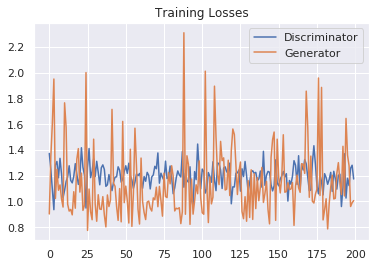

In [12]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [13]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [14]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

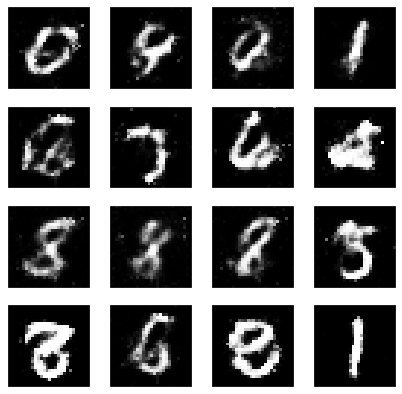

In [15]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

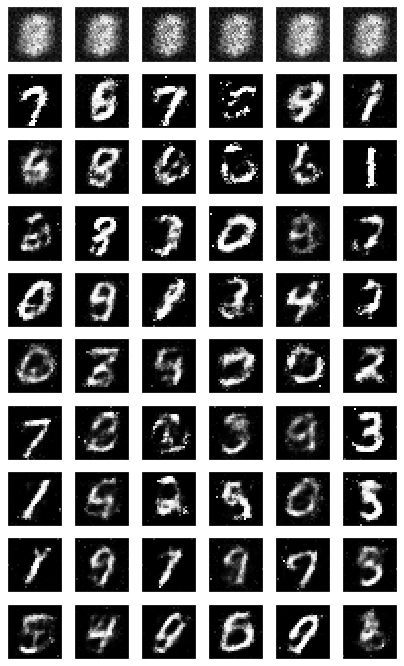

In [16]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/home/mahfuj/pytorch_new_python3/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


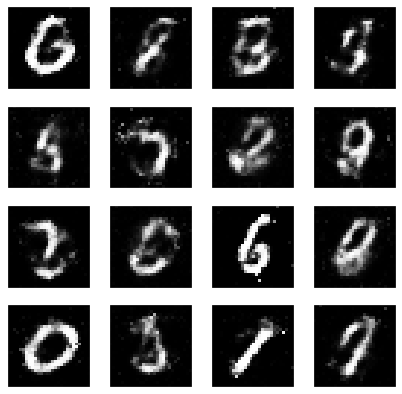

In [17]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
rand_z = rand_z.to(device)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])